In [ ]:
import sys; sys.path.append("..") 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.utility import loadfile, savefile, exists
from src.dataprocessing import *
from src import rnn

## load data

In [ ]:
# Define variables
input_var   = ["FT-3061-2", "FT-3061-3", "FT-3061-4", "FT-3062-1"]
output_var  = ["TT-3061-3", "TT-3061-5", "LT-3061-2"]
process_var = input_var + output_var

In [ ]:
min_len = 100
continuous_path = './data/3_continuous'

cts_list = []
i = 1
while exists(f"{continuous_path}/cts_{min_len}/dataset {min_len}_{i}.csv"):
    cts_df = loadfile(continuous_path, f"cts_{min_len}/dataset {min_len}_{i}", 'csv', print_msg=False)
    cts_list.append(cts_df)
    i += 1

In [ ]:
update = False

# future 10

## data reshape

In [ ]:
target_list = cts_list

# history size and future size
history_size = 40
future_size = 10
step = 1

# variable selection
history_var = process_var
future_var = output_var

history_num = len(history_var)
future_num = len(future_var)

# data to series
history_series = []
future_series = []
for i in range(len(target_list)):
    history, future = data2series(target_list[i], history_size, history_var, future_size, future_var,
                                step, start_idx=0, end_idx=None)
    if not i:
        history_series = history
        future_series = future
    else:
        history_series = np.concatenate([history_series, history], axis=0)
        future_series = np.concatenate([future_series, future], axis=0)
        
# supervised attention factor
delta_list = [0.5, 1, 1.5, 2, 2.5]
att_list = ['linear', 'exp']
        
# test data split        
test_size = 0.2
test_num = -1

# model structure
num_layers = 1
num_neurons = 50
dense_layers = 1
dense_neurons = 50
model_type = 'datt_seq2seq_gru'

iteration_list = [x for x in range(1,8)]
i=0
for iteration in iteration_list:
    for att_type in att_list:
        for delta in delta_list:
            model_num = iteration
            model_name = f"{history_size}_{future_size}_{num_layers}_{num_neurons}_{dense_layers}_{dense_neurons}_{model_type}_{att_type}_{delta}_{model_num}"
            result = loadfile('./result', model_name, file_type='csv', header=1, print_msg=False)
            result.columns = ['R2_TT-3061-3', 'R2_TT-3061-5', 'R2_LT-3061-2', 'R2_MEAN', 'NRMSE_TT-3061-3', 'NRMSE_TT-3061-5', 'NRMSE_LT-3061-2', 'NRMSE_MEAN']
            time_steps = pd.DataFrame([f't+{i+1}' for i in range(future_size)]+['mean'], columns=['step'])
            result = pd.concat([result, time_steps], axis=1)
            result['att_type'] = att_type
            result['delta'] = delta
            result['iteration'] = iteration
            if not i:
                result_reshape = result
            else:
                result_reshape = pd.concat([result_reshape, result], axis=0)
            i += 1

## Figure

## according to steps

R2 results


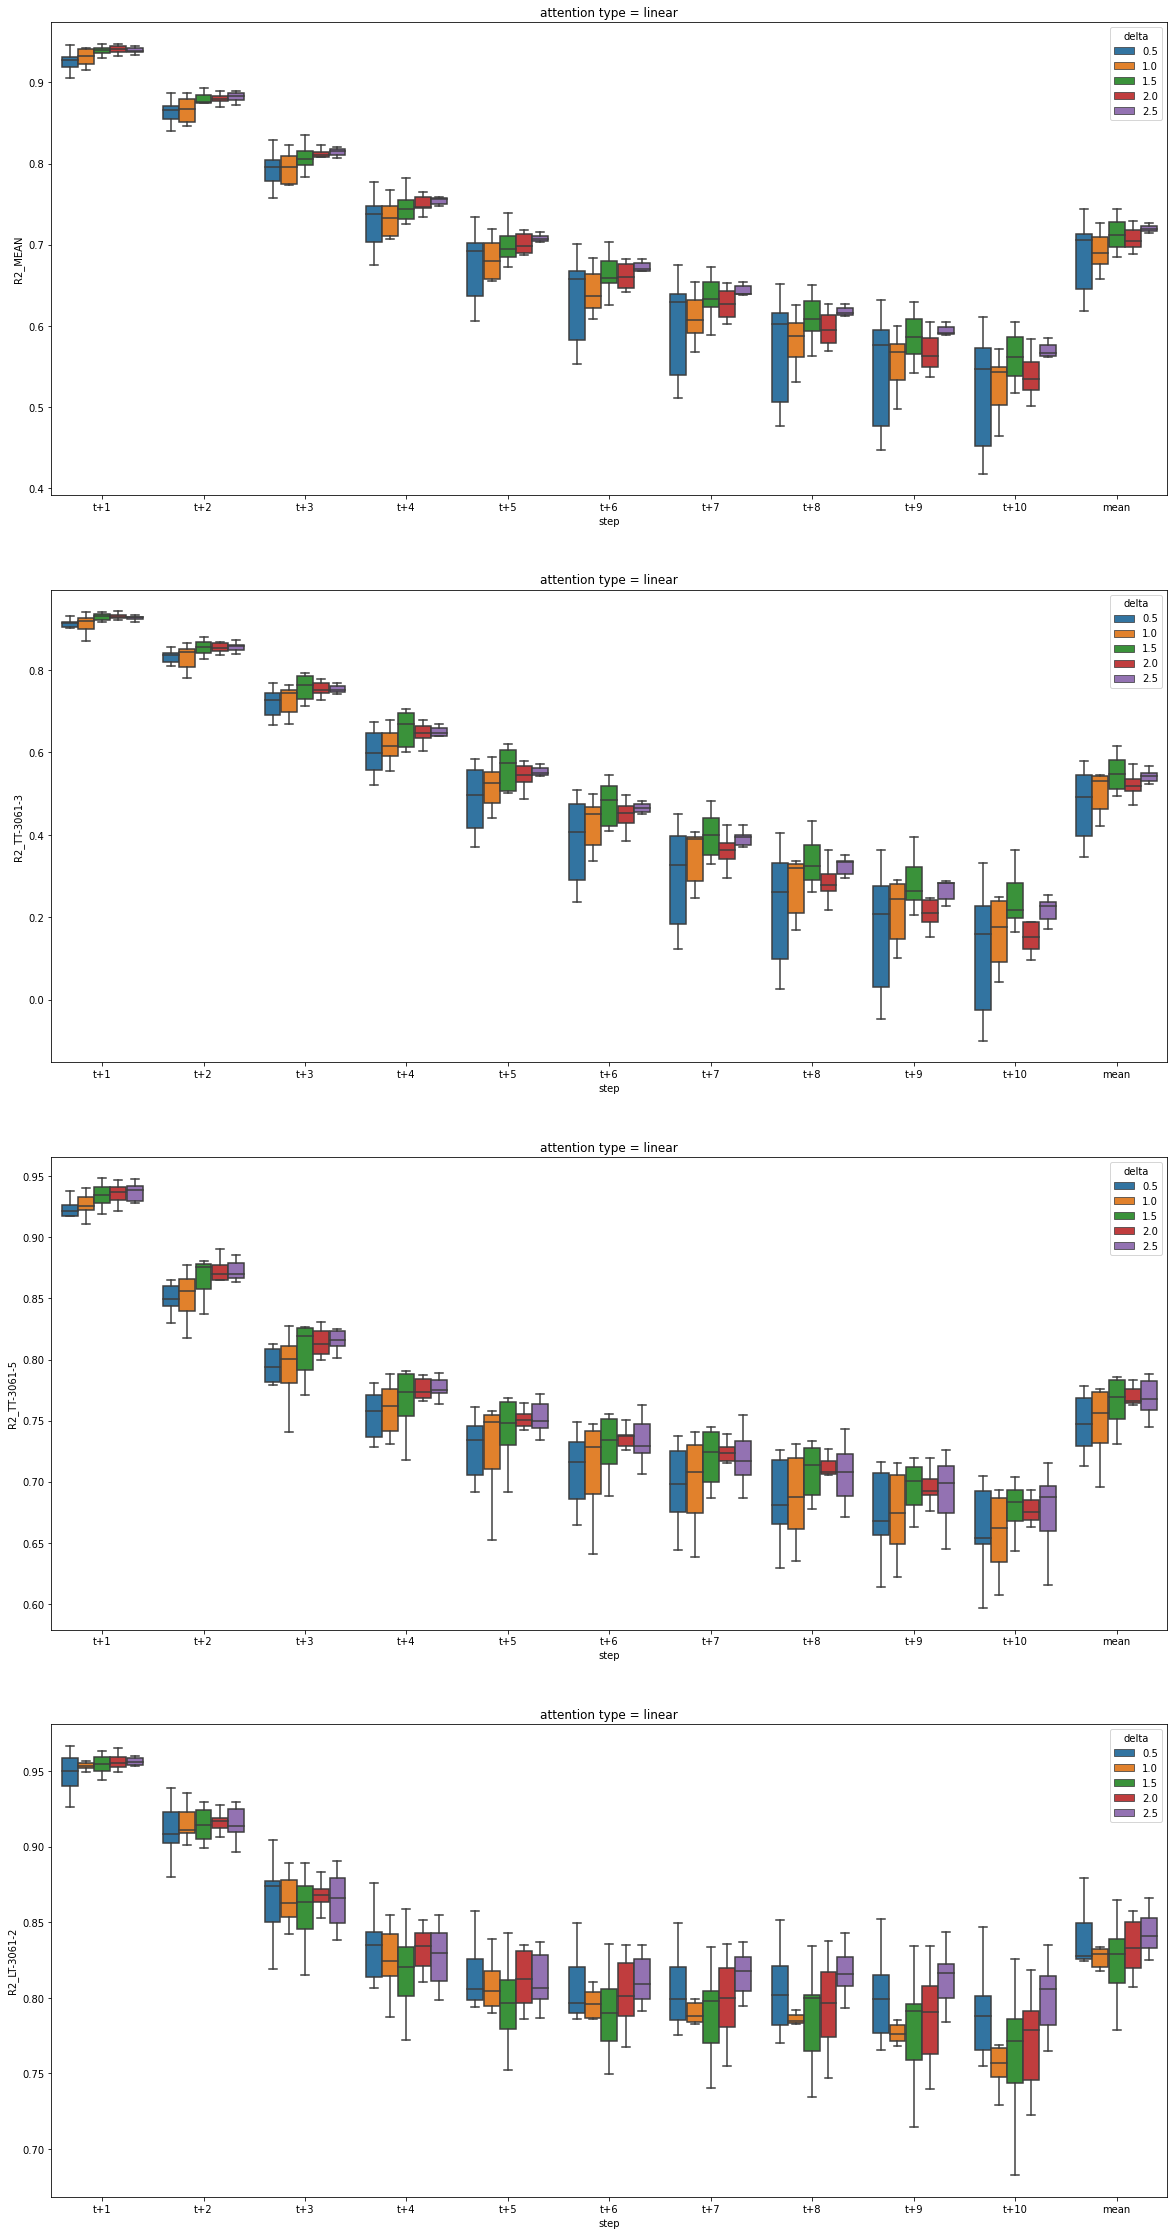

NRMSE results


<Figure size 432x288 with 0 Axes>

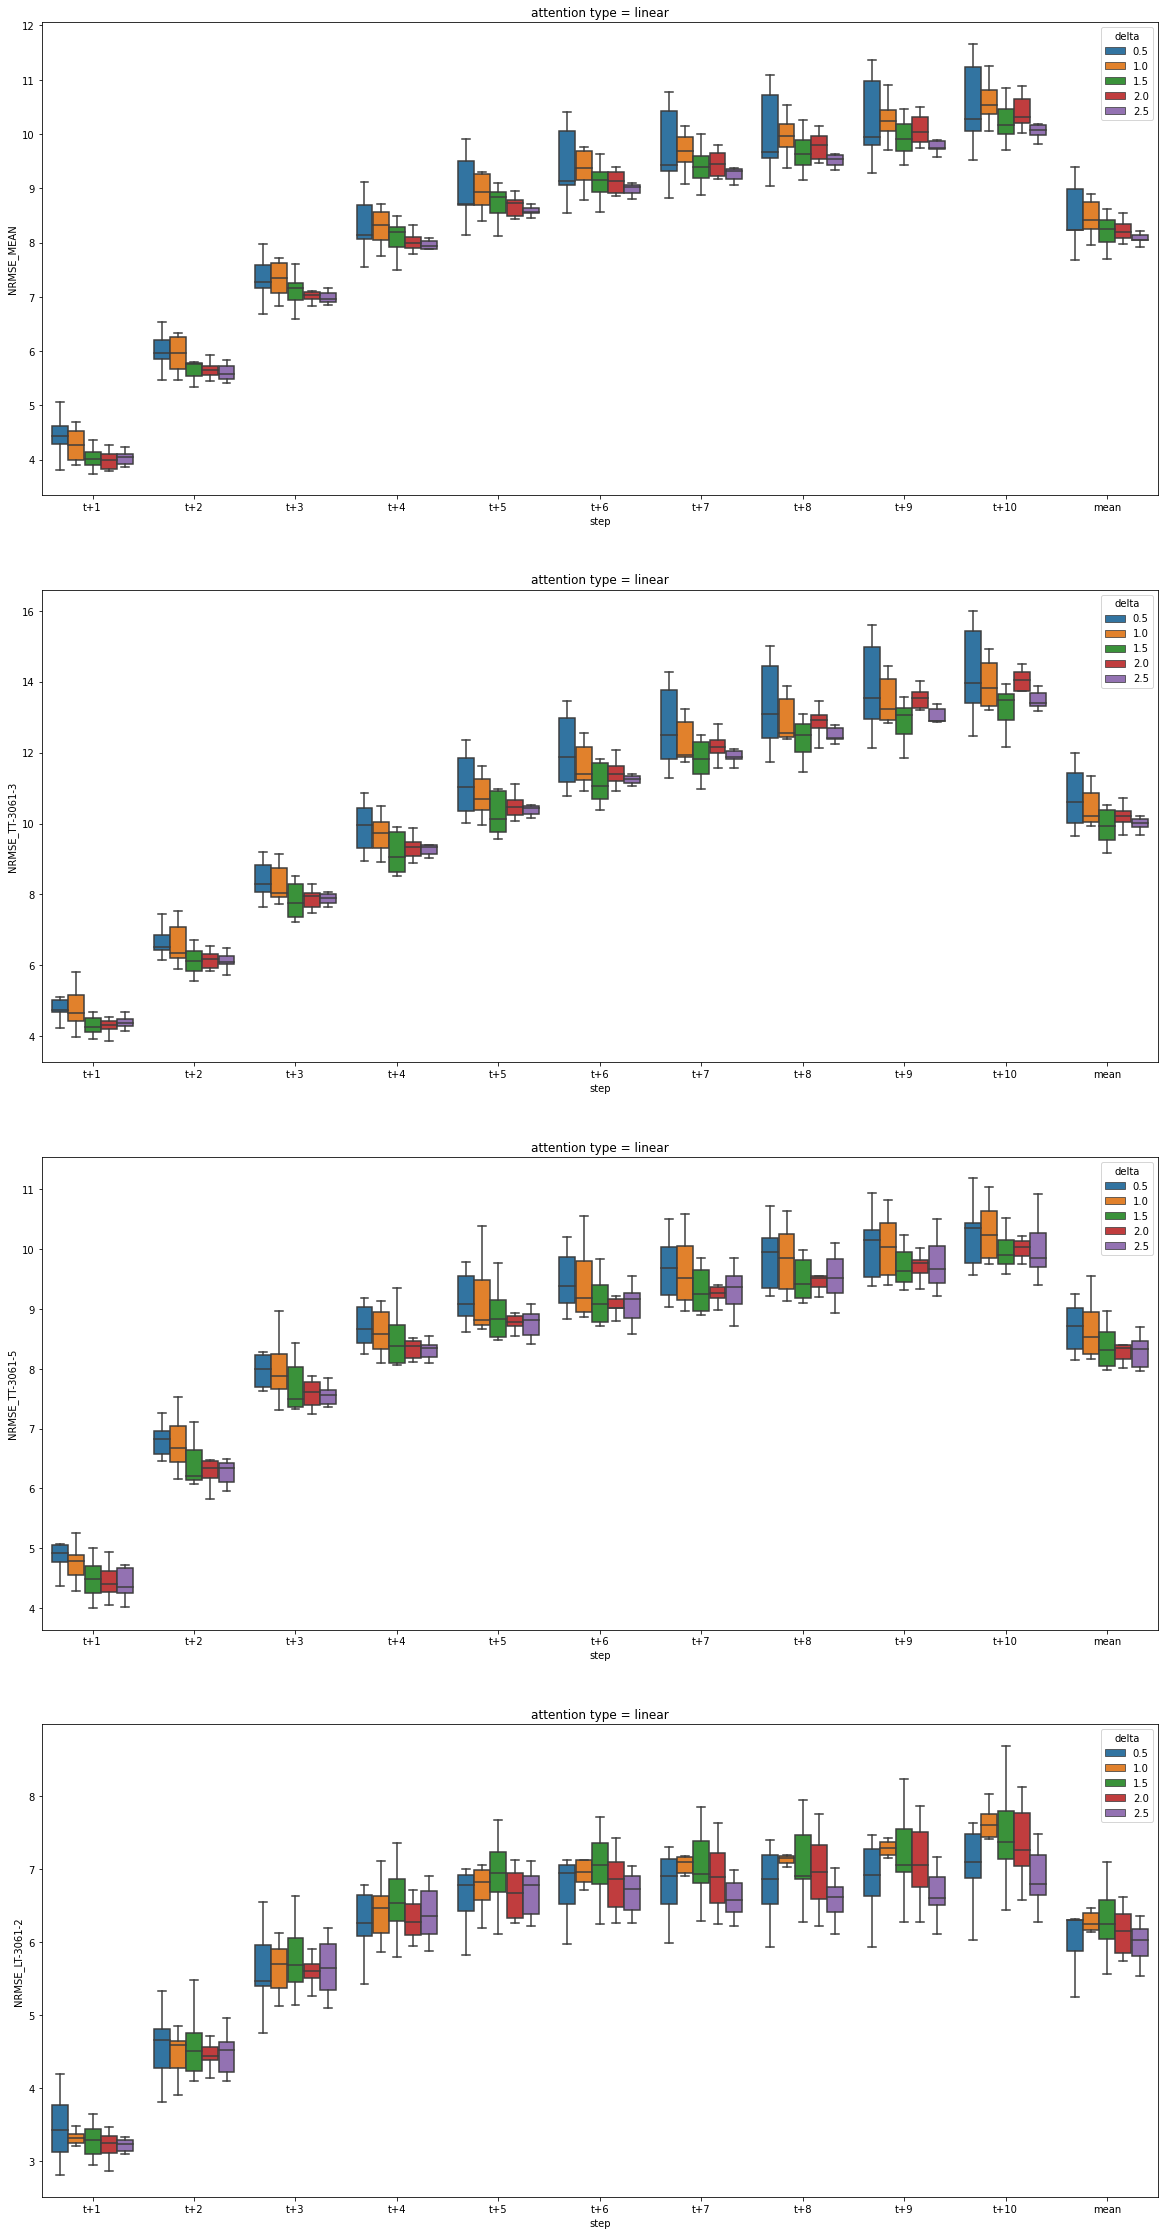

<Figure size 432x288 with 0 Axes>

In [ ]:
data = result_reshape

plot_var = ['R2_MEAN', 'R2_TT-3061-3', 'R2_TT-3061-5', 'R2_LT-3061-2']
att_type = 'linear'

print("R2 results")
plt.figure(figsize=(future_size*2,len(plot_var)*10))
for i, var in enumerate(plot_var):
    plt.subplot(len(plot_var), 1, i+1)
    plot_data = data[data['att_type']==att_type]
    sns.boxplot(x='step', y=var, hue='delta', data=plot_data, notch=False, showfliers = False)
    # plt.ylim(-0.01, 0.3)
    plt.title(f"attention type = {att_type}")
    
figure_name = f'delta_comparison_linear_future_{future_size}_nrmse'
if not exists(f'./figure/{figure_name}.png') or update:
    savefile(_, './figure', figure_name, 'figure')
    
plt.show()
plt.tight_layout()

data = result_reshape

plot_var = ['NRMSE_MEAN', 'NRMSE_TT-3061-3', 'NRMSE_TT-3061-5', 'NRMSE_LT-3061-2']
att_type = 'linear'

print("NRMSE results")
plt.figure(figsize=(future_size*2,len(plot_var)*10))
for i, var in enumerate(plot_var):
    plt.subplot(len(plot_var), 1, i+1)
    plot_data = data[data['att_type']==att_type]
    sns.boxplot(x='step', y=var, hue='delta', data=plot_data, notch=False, showfliers = False)
    # plt.ylim(-0.01, 0.3)
    plt.title(f"attention type = {att_type}")
    
figure_name = f'delta_comparison_linear_future_{future_size}_nrmse'
if not exists(f'./figure/{figure_name}.png') or update:
    savefile(_, './figure', figure_name, 'figure')
    
plt.show()
plt.tight_layout()

## delta & type comparison

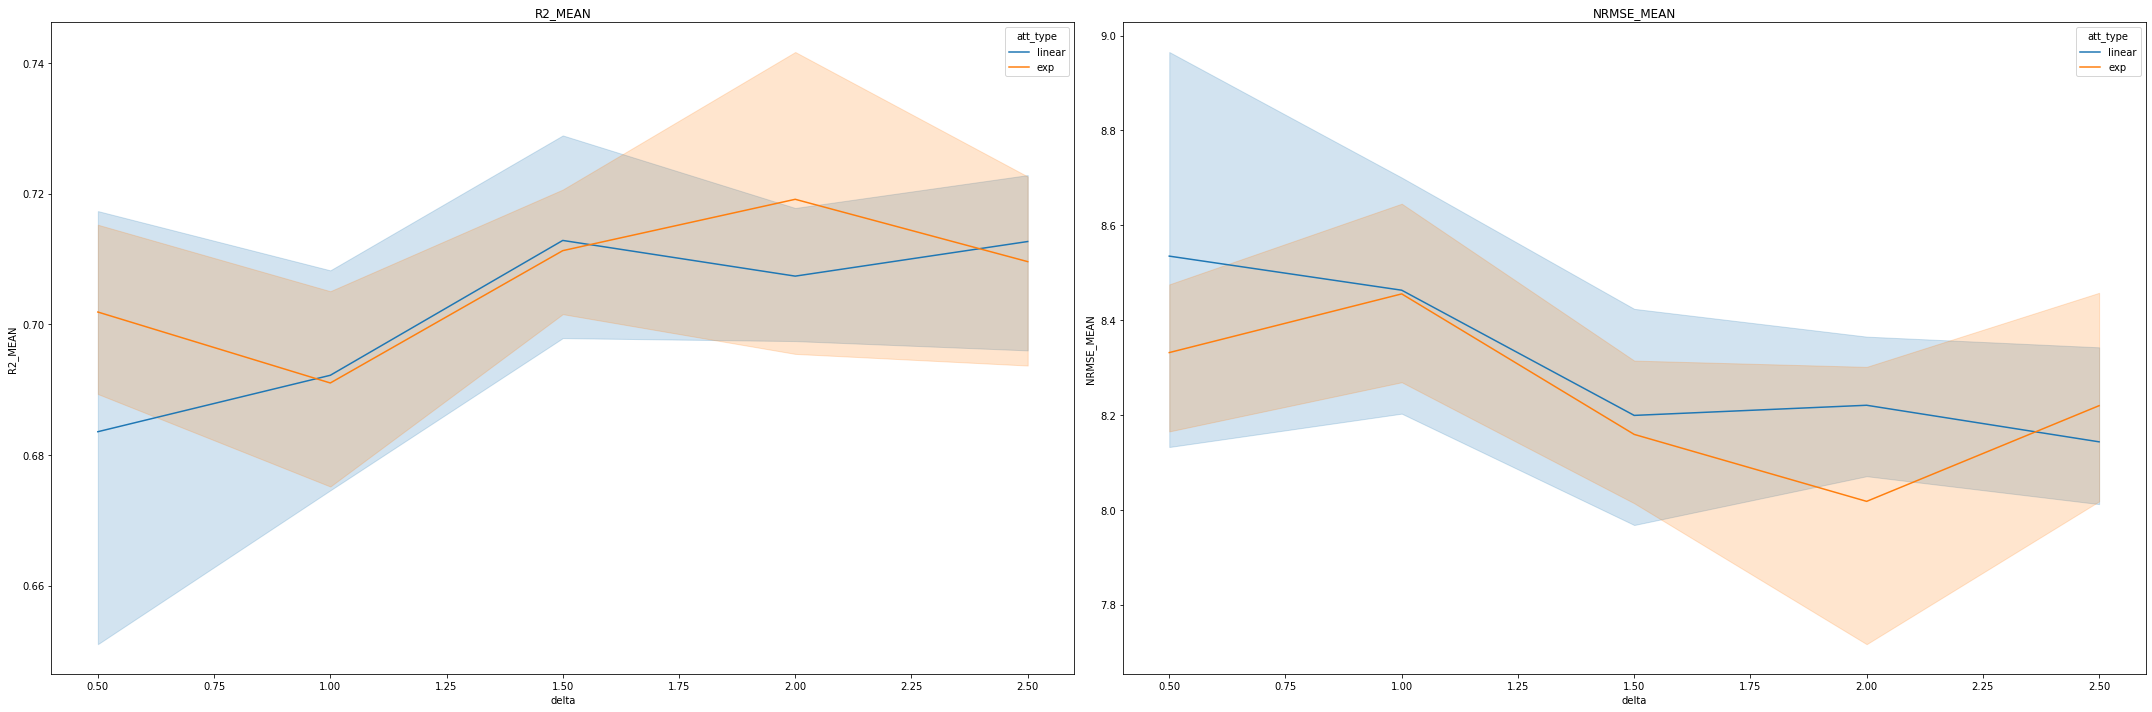

In [ ]:
data = result_reshape
plot_idx = ['R2_MEAN', 'NRMSE_MEAN']

plt.figure(figsize=(15*len(plot_idx), 10))
data_plot = data[(data['step']=='mean')].reset_index()
for i, idx in enumerate(plot_idx):
    plt.subplot(1, len(plot_idx), i+1)
    sns.lineplot(x='delta', y=idx, hue='att_type', markers=True, data=data_plot)
    plt.title(idx)
plt.tight_layout()
figure_name = f'fig2_delta_comparison_future_{future_size}'
if not exists(f'./figure/{figure_name}.png') or update:
    savefile(_, './figure', figure_name, 'figure')
plt.show()
